<a href="https://colab.research.google.com/github/anirbanghoshsbi/.github.io/blob/master/correlation/folder/nifty_usd_correlation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
import warnings
warnings.simplefilter(action='ignore', category=Warning)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
import datetime

In [10]:
data=pd.read_csv('/content/usd.csv')

In [11]:
data.head(2)

,time,open,high,low,close,"USDINR, IDC: Open","USDINR, IDC: High","USDINR, IDC: Low","USDINR, IDC: Close",Volume,Volume MA
0,1390275900,6320.1499,6330.2998,6297.8999,6313.7998,61.540,62.08,61.44,61.87,NaN,NaN
1,1390362300,6309.0498,6349.9502,6287.4502,6338.9502,61.878,62.01,61.77,61.82,NaN,NaN


In [12]:
data['date']=data.time.apply(lambda d: datetime.datetime.fromtimestamp(int(d)).strftime('%d-%m-%Y'))

In [13]:
del data['time']

In [14]:
data= data.set_index('date')

In [15]:
data.head(2)

,open,high,low,close,"USDINR, IDC: Open","USDINR, IDC: High","USDINR, IDC: Low","USDINR, IDC: Close",Volume,Volume MA
date,,,,,,,,,,
21-01-2014,6320.1499,6330.2998,6297.8999,6313.7998,61.540,62.08,61.44,61.87,NaN,NaN
22-01-2014,6309.0498,6349.9502,6287.4502,6338.9502,61.878,62.01,61.77,61.82,NaN,NaN


In [16]:
data=data['24-02-2016':]

In [17]:
data_subset=data[['close','USDINR, IDC: Close']]

In [18]:
data_subset.tail()

,close,"USDINR, IDC: Close"
date,,
02-02-2022,17780.000,74.796
03-02-2022,17560.199,74.639
04-02-2022,17516.301,74.640
07-02-2022,17213.600,74.638
08-02-2022,17266.750,74.690


In [19]:
data_subset.columns=['close','close1']

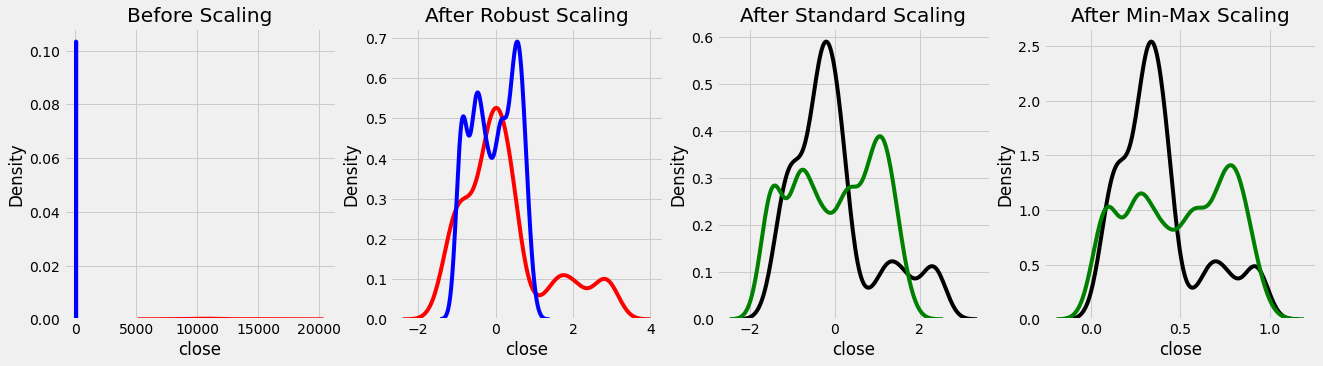

In [20]:
# Importing libraries
from sklearn import preprocessing
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns 
% matplotlib inline
matplotlib.style.use('fivethirtyeight')

# data
x = data_subset
scaler = preprocessing.RobustScaler()
robust_df = scaler.fit_transform(x)
robust_df = pd.DataFrame(robust_df, columns =['close','close1'])

scaler = preprocessing.StandardScaler()
standard_df = scaler.fit_transform(x)
standard_df = pd.DataFrame(standard_df, columns =['close','close1'])

scaler = preprocessing.MinMaxScaler()
minmax_df = scaler.fit_transform(x)
minmax_df = pd.DataFrame(minmax_df, columns =['close','close1'])

fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols = 4, figsize =(20, 5))
ax1.set_title('Before Scaling')

sns.kdeplot(x['close'], ax = ax1, color ='r')
sns.kdeplot(x['close1'], ax = ax1, color ='b')
ax2.set_title('After Robust Scaling')

sns.kdeplot(robust_df['close'], ax = ax2, color ='red')
sns.kdeplot(robust_df['close1'], ax = ax2, color ='blue')
ax3.set_title('After Standard Scaling')

sns.kdeplot(standard_df['close'], ax = ax3, color ='black')
sns.kdeplot(standard_df['close1'], ax = ax3, color ='g')
ax4.set_title('After Min-Max Scaling')

sns.kdeplot(minmax_df['close'], ax = ax4, color ='black')
sns.kdeplot(minmax_df['close1'], ax = ax4, color ='g')
plt.show()


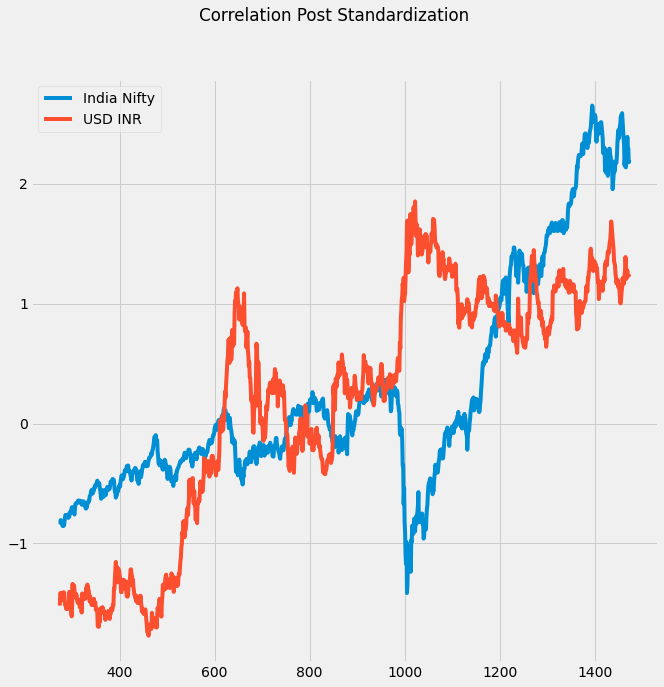

In [21]:
columns=['India Nifty','USD INR']
standard_df=standard_df.fillna(method='ffill')
standard_df.columns=columns
standard_df[-1200:].plot(figsize=(10,10))
plt.suptitle('Correlation Post Standardization')
plt.show()

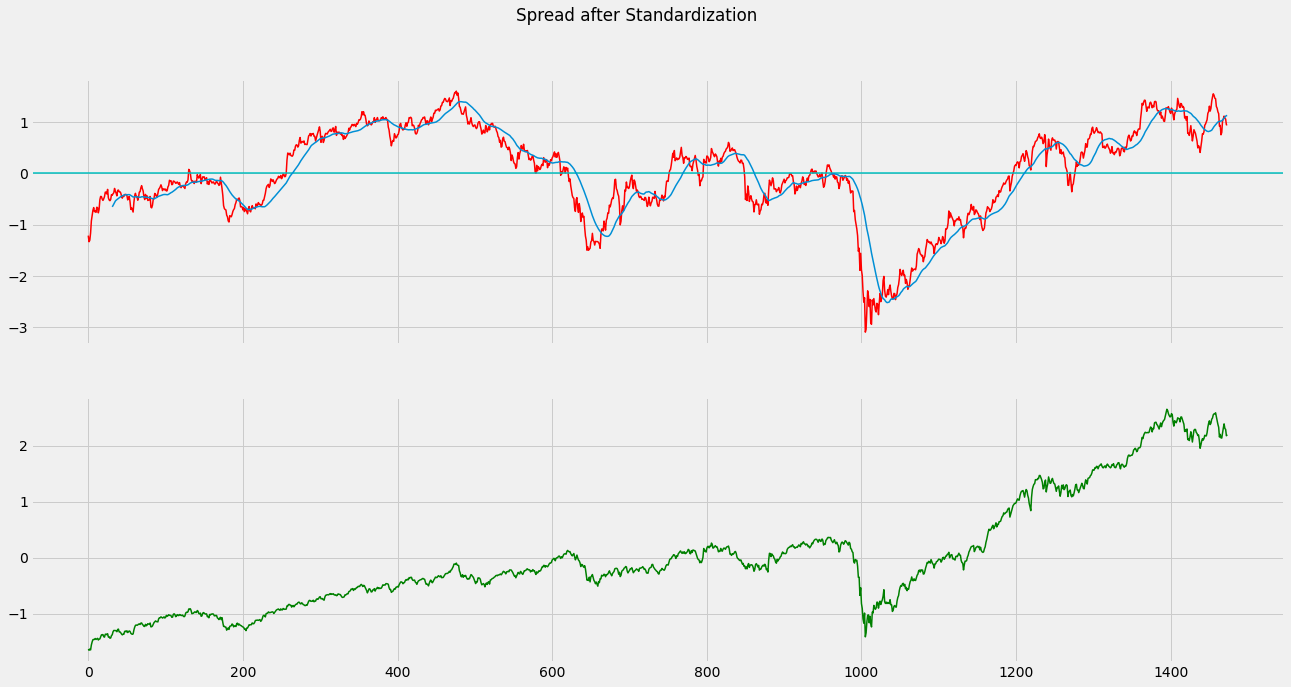

In [22]:
standard_df['diff']=standard_df['India Nifty']-standard_df['USD INR']
standard_df['mov_avg']=standard_df['diff'].rolling(window=32).mean()
plt.rcParams["figure.figsize"] = (20,10)
fig,ax=plt.subplots(2,1,sharex=True)
ax[0].plot(standard_df['diff'],color='r',lw=1.5)
ax[1].plot(standard_df['India Nifty'],color='g',lw=1.5)
ax[0].axhline(y=0,color='c',lw=1.5)
#ax[0].axhline(y=-3,color='g')
plt.suptitle('Spread after Standardization')
ax[0].plot(standard_df['mov_avg'],lw=1.5)
plt.show()

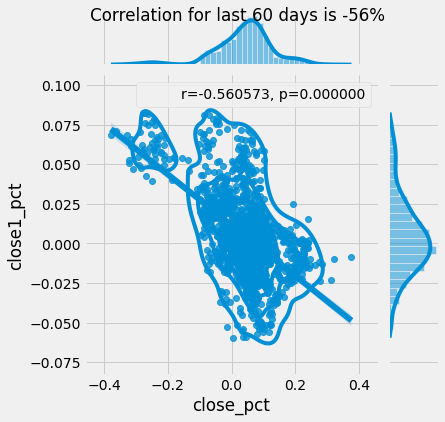

In [23]:
data_subset['close_pct']=data_subset['close'].pct_change(60)
data_subset['close1_pct']=data_subset['close1'].pct_change(60)

data_subset.dropna(inplace=True)
g=sns.jointplot(x='close_pct',y='close1_pct',data=data_subset,kind='reg').plot_joint(sns.kdeplot,n_levels=6)
r, p = pearsonr(data_subset['close_pct'], data_subset['close1_pct'])
phantom, = g.ax_joint.plot([], [], linestyle="", alpha=0)
g.ax_joint.legend([phantom],['r={:f}, p={:f}'.format(r,p)])
plt.suptitle(f'Correlation for last 60 days is {round(r*100)}%')
plt.show()